In [1]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [2]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [3]:
N = 25 #Number of experiments
size_of_msg = 0 #number of relevant bytes in a message (to be computed as we load the logs)
size_of_interaction = 3 #number of messages in complete interactions between client and server

def logToPositions(filename):
    global size_of_msg
    file = open(filename)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('#CLI: Heh, heh, heh... what a mess!'):
            raise Exception('There was an error in the execution of this protocol ' + filename)
        elif line.startswith('#CLI:') or line.startswith('#APP:'):
            continue
        elif line.startswith('#'):
            positions = line[1:].strip().split(',')[:-1]
            if (size_of_msg == 0):
                size_of_msg=len(positions)
            for p in positions:
                yield float(p)
    if not found_christmas:
        print('WARNING! Logs may not be complete for ' + filename)

In [4]:
def  loadAllPositions(base, N, pad=False):
    all_positions = []
    max_len = 0
    for i in range(1,N+1):
        positions = list(logToPositions(base+str(i)+'.log'))
        if len(positions) > max_len:
            max_len = len(positions)
        all_positions.append(np.array(list(positions)))
    if pad:
        for i in range(0,len(all_positions)):
            all_positions[i] = np.pad(all_positions[i], (0, max_len-len(all_positions[i])), 'constant', constant_values=np.nan)        
    return all_positions

WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs1.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs2.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs3.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs5.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs6.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs8.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs9.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs10.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs11.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs12.log
WARNING! Logs may not be co

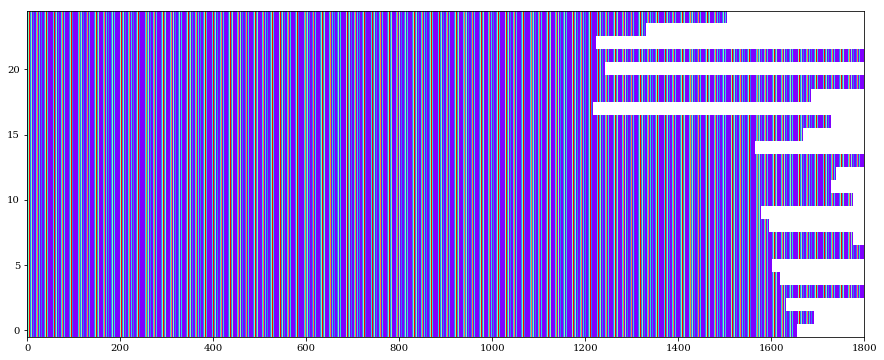

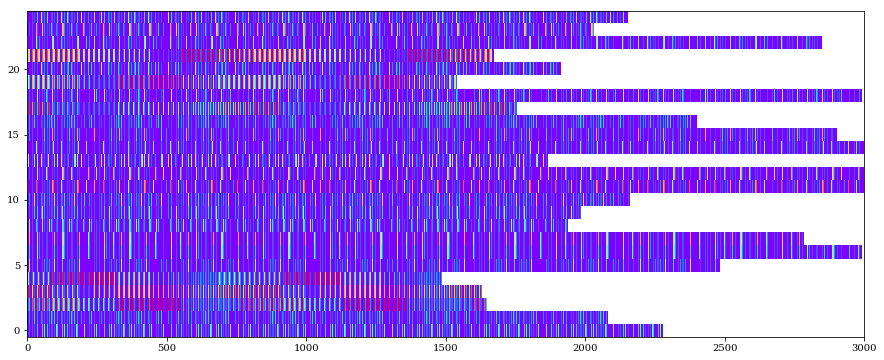

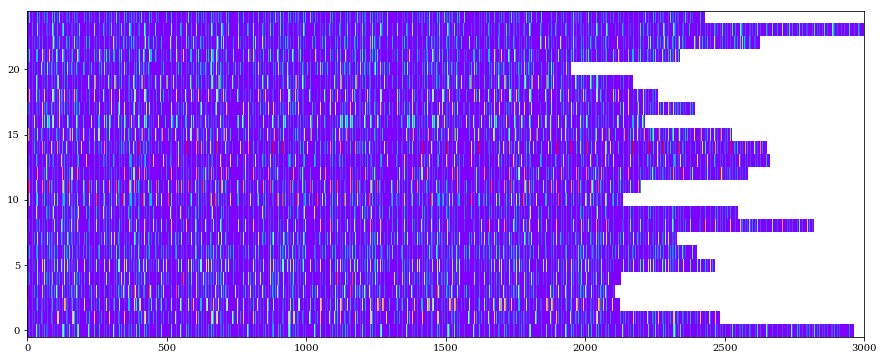

In [5]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N, pad=True))
static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N, pad=True))
runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N, pad=True))

plt.figure(1, figsize=(15,6))
plt.imshow(base_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_base.png', dpi=300)
plt.show()
plt.figure(2, figsize=(15,6))
plt.imshow(static_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_static.png', dpi=300)
plt.show()
plt.figure(3, figsize=(15,6))
plt.imshow(runtime_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
plt.savefig('picture_raw_positions_runtime.png', dpi=300)
plt.show()

In [6]:
def split_train_test(data, train_ratio = 0.67):
    train_test = np.empty([len(data),2], dtype=object)
    for i in range(0,len(data)):
        train_size = int(len(data[i]) * train_ratio)
        test_size = len(data[i]) - train_size
        train, test = data[i][0:train_size], data[i][train_size:len(data[i])]
        train_test[i][0] = train 
        train_test[i][1] = test
    return train_test

#Scale data to fit into y=[0,1]
#train = MinMaxScaler().fit_transform(train.reshape(-1, 1))
#test = MinMaxScaler().fit_transform(test.reshape(-1, 1))

base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N))
static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N))
runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N))

base = split_train_test(base_positions)
static = split_train_test(static_positions)
runtime = split_train_test(runtime_positions)

base_train = np.array(base[:, 0])
base_test = np.array(base[:, 1])
static_train = np.array(static[:, 0])
static_test = np.array(static[:, 1])
runtime_train = np.array(runtime[:, 0])
runtime_test = np.array(runtime[:, 1])

WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs1.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs2.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs3.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs5.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs6.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs8.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs9.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs10.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs11.log
WARNING! Logs may not be complete for ../../../target/thingml-bytes-logs/nodejs/base/nodejs12.log
WARNING! Logs may not be co

In [7]:
number_of_interactions = 3
size_of_window = number_of_interactions * size_of_interaction * size_of_msg

"""
See https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg   

In [8]:
def reshape(train, test):
    train_X = np.array(train.iloc[:,0:-1])
    train_Y = np.array(train.iloc[:,-1])
    test_X = np.array(test.iloc[:,0:-1])
    test_Y = np.array(test.iloc[:,-1])

    train_Y = np.reshape(train_Y, (train_Y.shape[0],1))
    test_Y = np.reshape(test_Y, (test_Y.shape[0],1))

    #FIXME: make a function
    n = train_X.shape[0]
    L = 3
    X_train_seq = []
    Y_train_seq = []
    for k in range(n - L + 1):
        X_train_seq.append(train_X[k : k + L])
        Y_train_seq.append(train_Y[k : k + L])
    train_X = np.array(X_train_seq)
    train_Y = np.array(Y_train_seq)

    #FIXME: make a function
    n = test_X.shape[0]
    L = 3
    X_test_seq = []
    Y_test_seq = []
    for k in range(n - L + 1):
        X_test_seq.append(test_X[k : k + L])
        Y_test_seq.append(test_Y[k : k + L])
    test_X = np.array(X_test_seq)
    test_Y = np.array(Y_test_seq)
    
    return train_X, train_Y, test_X, test_Y

def keras_model(x, y, cuda=True):
    model = keras.Sequential()
    model.add(keras.layers.Dense(x, input_shape=(y, x)))
    if cuda:
        model.add(keras.layers.CuDNNLSTM(x, return_sequences=True))
    else:
        model.add(keras.layers.LSTM(x, input_shape=(y, x), return_sequences=True))
    model.add(keras.layers.Dense(x))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer="adam")
#     model.summary()
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.005, patience=5, verbose=1)
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=1)
    callbacks_list = [earlystop_loss, earlystop_val_loss]
    
    model.fit(train_X, train_Y, batch_size=12, epochs=train_X.shape[2], validation_split=0.1, verbose=1, callbacks=callbacks_list)

    if save:
        keras.models.save_model(model, base_dir + mode + str(xp) + '.h5', overwrite=True, include_optimizer=True)
#         json = model.to_json()
#         text_file = open(base_dir + mode + str(xp) + '.json', "w")
#         text_file.write(json)
#         text_file.close()
        
    
#     result = model.evaluate(test_X, test_Y)
#     print(result)
    return model

In [9]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)
    predictions = np.round(predictions)

    error = np.abs(test_Y.flatten() - predictions.flatten())
    condition = np.equal(error, 0)
    matches = np.extract(condition, error)

    RMSD = round(math.sqrt(np.sum(error**2)/len(error)),2)
    error_ratio = 100-round((len(matches)/len(error)*100),2)

    return error_ratio, RMSD

In [10]:
def xp(train_set, test_set, mode):
    print('xp ', mode)
    for i in range(0, N):
        print('    #', str(i))
        train = series_to_supervised(list(train_set[i]), size_of_window, 1)
        test = series_to_supervised(list(test_set[i]), size_of_window, 1) 
        train_X, train_Y, test_X, test_Y = reshape(train, test)
        model = keras_model(train_X.shape[2], train_X.shape[1])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X, train_Y, test_X, test_Y, mode, i, save=True)
        train_stop = predict_start = datetime.datetime.now()
        match_ratio, RMSD = predict(model, test_X, test_Y)
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print('RMSD = ', RMSD)
        print(match_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        yield match_ratio, RMSD, train_duration, predict_duration

In [11]:
base_xp = xp(base_train, base_test, 'base')
base_results = list(base_xp)

static_xp = xp(static_train, static_test, 'static')
static_results = list(static_xp)

runtime_xp = xp(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_xp)

xp  base
    # 0
Train on 947 samples, validate on 106 samples
Epoch 1/54
947/947 [==============================] - 4s 5ms/step - loss: 0.6611 - val_loss: 0.0126
Epoch 2/54
947/947 [==============================] - 0s 496us/step - loss: 0.0041 - val_loss: 9.9247e-04
Epoch 3/54
947/947 [==============================] - 0s 492us/step - loss: 5.9811e-04 - val_loss: 2.9545e-04
Epoch 4/54
947/947 [==============================] - 0s 491us/step - loss: 1.9967e-04 - val_loss: 1.2813e-04
Epoch 5/54
947/947 [==============================] - 0s 493us/step - loss: 6.8134e-05 - val_loss: 3.1609e-05
Epoch 6/54
947/947 [==============================] - 0s 491us/step - loss: 1.8956e-05 - val_loss: 1.0225e-05
Epoch 7/54
947/947 [==============================] - 0s 503us/step - loss: 6.0034e-06 - val_loss: 2.7447e-06
Epoch 00007: early stopping
Epoch 00007: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:08.104214
prediction duration =  0:00:00.127268
    # 1
Train on 969 sample

911/911 [==============================] - 0s 508us/step - loss: 2.3272e-05 - val_loss: 1.5151e-05
Epoch 00007: early stopping
Epoch 00007: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:05.904968
prediction duration =  0:00:00.343310
    # 9
Train on 900 samples, validate on 101 samples
Epoch 1/54
900/900 [==============================] - 2s 2ms/step - loss: 0.5848 - val_loss: 0.0099
Epoch 2/54
900/900 [==============================] - 0s 521us/step - loss: 0.0027 - val_loss: 8.1652e-04
Epoch 3/54
900/900 [==============================] - 0s 520us/step - loss: 4.4170e-04 - val_loss: 2.4015e-04
Epoch 4/54
900/900 [==============================] - 0s 517us/step - loss: 1.5415e-04 - val_loss: 8.2624e-05
Epoch 5/54
900/900 [==============================] - 0s 536us/step - loss: 5.9855e-05 - val_loss: 3.5812e-05
Epoch 6/54
900/900 [==============================] - 0s 520us/step - loss: 2.1623e-05 - val_loss: 1.5352e-05
Epoch 7/54
900/900 [===========================

684/684 [==============================] - 0s 548us/step - loss: 1.6907e-04 - val_loss: 1.0424e-04
Epoch 6/54
684/684 [==============================] - 0s 557us/step - loss: 8.3683e-05 - val_loss: 6.0110e-05
Epoch 7/54
684/684 [==============================] - 0s 545us/step - loss: 4.9355e-05 - val_loss: 3.5184e-05
Epoch 00007: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:06.958765
prediction duration =  0:00:00.622181
    # 18
Train on 965 samples, validate on 108 samples
Epoch 1/54
965/965 [==============================] - 3s 3ms/step - loss: 0.5554 - val_loss: 0.0063
Epoch 2/54
965/965 [==============================] - 1s 541us/step - loss: 0.0018 - val_loss: 5.2295e-04
Epoch 3/54
965/965 [==============================] - 1s 547us/step - loss: 3.1250e-04 - val_loss: 1.6135e-04
Epoch 4/54
965/965 [==============================] - 1s 556us/step - loss: 1.0045e-04 - val_loss: 5.6294e-05
Epoch 5/54
965/965 [==============================] - 1s 551us/step - loss

Epoch 4/54
1204/1204 [==============================] - 1s 564us/step - loss: 7.2846e-05 - val_loss: 3.8594e-05
Epoch 5/54
1204/1204 [==============================] - 1s 561us/step - loss: 2.6969e-05 - val_loss: 1.7215e-05
Epoch 6/54
1204/1204 [==============================] - 1s 569us/step - loss: 1.2120e-05 - val_loss: 7.0601e-06
Epoch 00006: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:10.169448
prediction duration =  0:00:00.952972
    # 2
Train on 944 samples, validate on 105 samples
Epoch 1/54
944/944 [==============================] - 4s 4ms/step - loss: 1.1355 - val_loss: 0.0154
Epoch 2/54
944/944 [==============================] - 1s 563us/step - loss: 0.0032 - val_loss: 3.3539e-04
Epoch 3/54
944/944 [==============================] - 1s 565us/step - loss: 1.8787e-04 - val_loss: 8.9114e-05
Epoch 4/54
944/944 [==============================] - 1s 557us/step - loss: 6.5297e-05 - val_loss: 3.6056e-05
Epoch 5/54
944/944 [==============================] - 1s 5

1251/1251 [==============================] - 1s 575us/step - loss: 1.5223e-06 - val_loss: 7.4293e-07
Epoch 00006: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:11.726018
prediction duration =  0:00:01.257783
    # 11
Train on 1758 samples, validate on 196 samples
Epoch 1/54
1758/1758 [==============================] - 5s 3ms/step - loss: 0.4434 - val_loss: 8.6808e-04
Epoch 2/54
1758/1758 [==============================] - 1s 577us/step - loss: 2.0648e-04 - val_loss: 2.4778e-05
Epoch 3/54
1758/1758 [==============================] - 1s 575us/step - loss: 1.9556e-05 - val_loss: 8.2428e-06
Epoch 4/54
1758/1758 [==============================] - 1s 572us/step - loss: 1.6279e-05 - val_loss: 5.3609e-05
Epoch 5/54
1758/1758 [==============================] - 1s 570us/step - loss: 5.0937e-04 - val_loss: 0.0013
Epoch 6/54
1758/1758 [==============================] - 1s 570us/step - loss: 0.0022 - val_loss: 3.3340e-04
Epoch 00006: early stopping
RMSD =  0.0
0.0 % error
trainin

Train on 1103 samples, validate on 123 samples
Epoch 1/54
1103/1103 [==============================] - 6s 5ms/step - loss: 0.2919 - val_loss: 0.0105
Epoch 2/54
1103/1103 [==============================] - 1s 594us/step - loss: 0.0028 - val_loss: 7.7498e-04
Epoch 3/54
1103/1103 [==============================] - 1s 588us/step - loss: 4.6911e-04 - val_loss: 2.0232e-04
Epoch 4/54
1103/1103 [==============================] - 1s 590us/step - loss: 1.1875e-04 - val_loss: 5.8980e-05
Epoch 5/54
1103/1103 [==============================] - 1s 587us/step - loss: 3.7465e-05 - val_loss: 2.0550e-05
Epoch 6/54
1103/1103 [==============================] - 1s 584us/step - loss: 1.3768e-05 - val_loss: 7.8005e-06
Epoch 7/54
1103/1103 [==============================] - 1s 591us/step - loss: 5.4768e-06 - val_loss: 3.4685e-06
Epoch 00007: early stopping
Epoch 00007: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:13.776492
prediction duration =  0:00:01.597676
    # 21
Train on 958 samples

1230/1230 [==============================] - 7s 6ms/step - loss: 3.4415 - val_loss: 3.2823
Epoch 2/54
1230/1230 [==============================] - 1s 601us/step - loss: 1.4743 - val_loss: 1.7515
Epoch 3/54
1230/1230 [==============================] - 1s 602us/step - loss: 0.6980 - val_loss: 1.1012
Epoch 4/54
1230/1230 [==============================] - 1s 597us/step - loss: 0.4227 - val_loss: 0.7150
Epoch 5/54
1230/1230 [==============================] - 1s 603us/step - loss: 0.3223 - val_loss: 0.6261
Epoch 6/54
1230/1230 [==============================] - 1s 602us/step - loss: 0.2415 - val_loss: 0.6067
Epoch 7/54
1230/1230 [==============================] - 1s 600us/step - loss: 0.2121 - val_loss: 0.6467
Epoch 8/54
1230/1230 [==============================] - 1s 605us/step - loss: 0.2012 - val_loss: 0.5583
Epoch 9/54
1230/1230 [==============================] - 1s 643us/step - loss: 0.1870 - val_loss: 0.5689
Epoch 10/54
1230/1230 [==============================] - 1s 631us/step - loss

Epoch 4/54
1396/1396 [==============================] - 1s 609us/step - loss: 0.1992 - val_loss: 0.2953
Epoch 5/54
1396/1396 [==============================] - 1s 610us/step - loss: 0.1734 - val_loss: 0.2549
Epoch 6/54
1396/1396 [==============================] - 1s 604us/step - loss: 0.1496 - val_loss: 0.2175
Epoch 7/54
1396/1396 [==============================] - 1s 603us/step - loss: 0.1466 - val_loss: 0.2114
Epoch 8/54
1396/1396 [==============================] - 1s 601us/step - loss: 0.1295 - val_loss: 0.2017
Epoch 9/54
1396/1396 [==============================] - 1s 612us/step - loss: 0.1263 - val_loss: 0.2156
Epoch 10/54
1396/1396 [==============================] - 1s 605us/step - loss: 0.1150 - val_loss: 0.2222
Epoch 11/54
1396/1396 [==============================] - 1s 610us/step - loss: 0.1114 - val_loss: 0.2047
Epoch 12/54
1396/1396 [==============================] - 1s 600us/step - loss: 0.1046 - val_loss: 0.2082
Epoch 13/54
1396/1396 [==============================] - 1s 6

RMSD =  0.71
8.469999999999999 % error
training duration =  0:00:30.163439
prediction duration =  0:00:02.232940
    # 11
Train on 1277 samples, validate on 142 samples
Epoch 1/54
1277/1277 [==============================] - 8s 6ms/step - loss: 2.8473 - val_loss: 2.2315
Epoch 2/54
1277/1277 [==============================] - 1s 630us/step - loss: 0.8655 - val_loss: 2.1784
Epoch 3/54
1277/1277 [==============================] - 1s 617us/step - loss: 0.7050 - val_loss: 2.2096
Epoch 4/54
1277/1277 [==============================] - 1s 618us/step - loss: 0.6509 - val_loss: 1.8532
Epoch 5/54
1277/1277 [==============================] - 1s 633us/step - loss: 0.6333 - val_loss: 2.0571
Epoch 6/54
1277/1277 [==============================] - 1s 617us/step - loss: 0.6114 - val_loss: 2.0209
Epoch 7/54
1277/1277 [==============================] - 1s 622us/step - loss: 0.5929 - val_loss: 1.9068
Epoch 8/54
1277/1277 [==============================] - 1s 617us/step - loss: 0.5924 - val_loss: 2.1210
E

1284/1284 [==============================] - 1s 626us/step - loss: 0.2053 - val_loss: 1.0024
Epoch 9/54
1284/1284 [==============================] - 1s 633us/step - loss: 0.1878 - val_loss: 1.0623
Epoch 10/54
1284/1284 [==============================] - 1s 617us/step - loss: 0.1777 - val_loss: 1.0300
Epoch 00010: early stopping
RMSD =  0.86
17.980000000000004 % error
training duration =  0:00:21.677279
prediction duration =  0:00:02.468148
    # 17
Train on 1392 samples, validate on 155 samples
Epoch 1/54
1392/1392 [==============================] - 9s 7ms/step - loss: 1.8133 - val_loss: 1.2166
Epoch 2/54
1392/1392 [==============================] - 1s 630us/step - loss: 0.9151 - val_loss: 0.9024
Epoch 3/54
1392/1392 [==============================] - 1s 624us/step - loss: 0.7601 - val_loss: 0.8309
Epoch 4/54
1392/1392 [==============================] - 1s 629us/step - loss: 0.6595 - val_loss: 0.9061
Epoch 5/54
1392/1392 [==============================] - 1s 626us/step - loss: 0.6105 -

Train on 1359 samples, validate on 152 samples
Epoch 1/54
1359/1359 [==============================] - 10s 7ms/step - loss: 1.3520 - val_loss: 0.5650
Epoch 2/54
1359/1359 [==============================] - 1s 649us/step - loss: 0.5342 - val_loss: 0.4181
Epoch 3/54
1359/1359 [==============================] - 1s 653us/step - loss: 0.3761 - val_loss: 0.5029
Epoch 4/54
1359/1359 [==============================] - 1s 651us/step - loss: 0.3333 - val_loss: 0.4455
Epoch 5/54
1359/1359 [==============================] - 1s 646us/step - loss: 0.2807 - val_loss: 0.4557
Epoch 6/54
1359/1359 [==============================] - 1s 649us/step - loss: 0.2631 - val_loss: 0.4614
Epoch 7/54
1359/1359 [==============================] - 1s 646us/step - loss: 0.2340 - val_loss: 0.6248
Epoch 00007: early stopping
RMSD =  0.64
15.620000000000005 % error
training duration =  0:00:20.821466
prediction duration =  0:00:02.675967
    # 22
Train on 1533 samples, validate on 171 samples
Epoch 1/54
1533/1533 [======

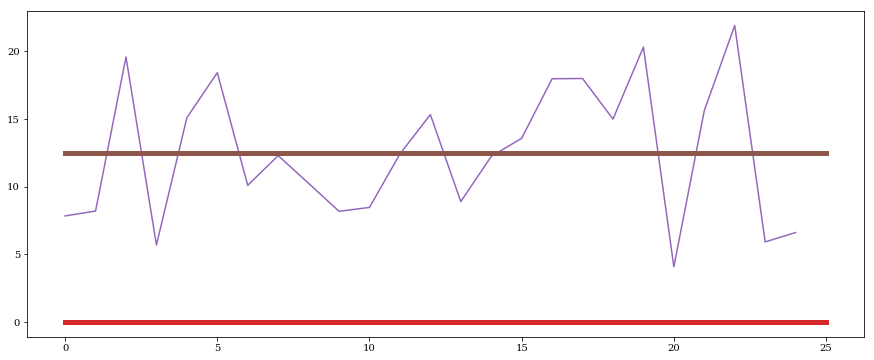

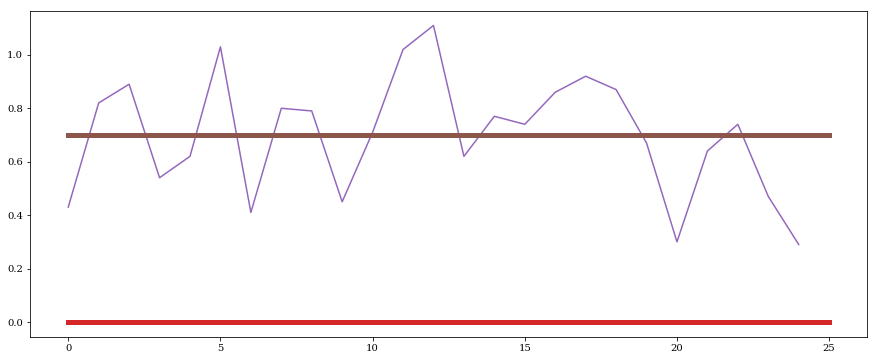

In [12]:
def get_errors_and_rmsd(results, errors, rmsd):
    for e,rms,_,_ in results:
        errors.append(e)
        rmsd.append(rms)

        
base_errors = []
base_rmsd = []
get_errors_and_rmsd(base_results, base_errors, base_rmsd)

static_errors = []
static_rmsd = []
get_errors_and_rmsd(static_results, static_errors, static_rmsd)

runtime_errors = []
runtime_rmsd = []
get_errors_and_rmsd(runtime_results, runtime_errors, runtime_rmsd)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(5, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

In [13]:
def xp2(train_set, test_set, mode):
    for i in range(0,N):
        model = keras.models.load_model(base_dir + mode + str(i) + '.h5')
        for j in range(0,N):
            print('    using model ', str(i), ' on data coming from ', str(j))
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1) 
            train_X, train_Y, test_X, test_Y = reshape(train, test)
            predict_start = datetime.datetime.now()
            match_ratio, RMSD = predict(model, test_X, test_Y)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print('RMSD = ', RMSD)
            print(match_ratio, '% error')
            print('prediction duration = ', predict_duration)
            yield match_ratio, RMSD, -1, predict_duration #-1 for no training

base_results = xp2(base_train, base_test, 'base')
base_results = list(base_results)

static_results = xp2(static_train, static_test, 'static')
static_results = list(static_results)

runtime_results = xp2(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_results)

    using model  0  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:02.826970
    using model  0  on data coming from  1
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.053110
    using model  0  on data coming from  2
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.052111
    using model  0  on data coming from  3
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.060129
    using model  0  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.048093
    using model  0  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.047093
    using model  0  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061139
    using model  0  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.054112
    using model  0  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.048096
    using model  0  on data coming from  9
RMSD =  0.0


RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.063137
    using model  3  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.049100
    using model  3  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.051104
    using model  3  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061133
    using model  3  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056118
    using model  3  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.048095
    using model  3  on data coming from  9
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056123
    using model  3  on data coming from  10
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055116
    using model  3  on data coming from  11
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.054110
    using model  3  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.063196
    using model  6  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.057152
    using model  6  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.050133
    using model  6  on data coming from  9
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055179
    using model  6  on data coming from  10
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055148
    using model  6  on data coming from  11
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056150
    using model  6  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061163
    using model  6  on data coming from  13
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055115
    using model  6  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.052139
    using model  6  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.064171
    using model  9  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.068182
    using model  9  on data coming from  13
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061163
    using model  9  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055147
    using model  9  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061163
    using model  9  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.062166
    using model  9  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.041110
    using model  9  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.066176
    using model  9  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.064157
    using model  9  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration = 

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.062165
    using model  12  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.058153
    using model  12  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.038100
    using model  12  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.058153
    using model  12  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.059156
    using model  12  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.041109
    using model  12  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.063166
    using model  12  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.044115
    using model  12  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.041110
    using model  12  on data coming from  24
RMSD =  0.0
0.0 % error
prediction du

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.058125
    using model  15  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.059124
    using model  15  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.042081
    using model  15  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.066143
    using model  15  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.039069
    using model  15  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.043080
    using model  15  on data coming from  24
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.052106
    using model  16  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:03.703101
    using model  16  on data coming from  1
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056151
    using model  16  on data coming from  2
RMSD =  0.0
0.0 % error
prediction durat

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.067179
    using model  18  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.039103
    using model  18  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.043117
    using model  18  on data coming from  24
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.049131
    using model  19  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:03.872813
    using model  19  on data coming from  1
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.058156
    using model  19  on data coming from  2
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.059157
    using model  19  on data coming from  3
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.070185
    using model  19  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.055120
    using model  19  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.052138
    using model  22  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:04.001886
    using model  22  on data coming from  1
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056117
    using model  22  on data coming from  2
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.057152
    using model  22  on data coming from  3
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.069157
    using model  22  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.056123
    using model  22  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.054145
    using model  22  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.064143
    using model  22  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.061162
    using model  22  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration = 

RMSD =  3.16
75.87 % error
prediction duration =  0:00:00.059130
    using model  0  on data coming from  3
RMSD =  3.4
77.98 % error
prediction duration =  0:00:00.066176
    using model  0  on data coming from  4
RMSD =  3.02
85.09 % error
prediction duration =  0:00:00.053109
    using model  0  on data coming from  5
RMSD =  1.14
38.61 % error
prediction duration =  0:00:00.086203
    using model  0  on data coming from  6
RMSD =  1.45
58.77 % error
prediction duration =  0:00:00.114275
    using model  0  on data coming from  7
RMSD =  2.03
69.95 % error
prediction duration =  0:00:00.101240
    using model  0  on data coming from  8
RMSD =  0.79
50.06 % error
prediction duration =  0:00:00.075169
    using model  0  on data coming from  9
RMSD =  0.63
36.11 % error
prediction duration =  0:00:00.068151
    using model  0  on data coming from  10
RMSD =  0.7
36.23 % error
prediction duration =  0:00:00.078178
    using model  0  on data coming from  11
RMSD =  2.21
62.31 % error
p

RMSD =  1.65
73.82 % error
prediction duration =  0:00:00.061163
    using model  3  on data coming from  3
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.064170
    using model  3  on data coming from  4
RMSD =  1.26
75.92 % error
prediction duration =  0:00:00.053113
    using model  3  on data coming from  5
RMSD =  1.52
65.58 % error
prediction duration =  0:00:00.089239
    using model  3  on data coming from  6
RMSD =  1.84
67.85 % error
prediction duration =  0:00:00.114265
    using model  3  on data coming from  7
RMSD =  2.5
76.63 % error
prediction duration =  0:00:00.100266
    using model  3  on data coming from  8
RMSD =  2.1
84.65 % error
prediction duration =  0:00:00.075165
    using model  3  on data coming from  9
RMSD =  1.47
75.0 % error
prediction duration =  0:00:00.072166
    using model  3  on data coming from  10
RMSD =  1.65
76.46000000000001 % error
prediction duration =  0:00:00.078179
    using model  3  on data coming from  11
RMSD =  2.69
77.77 %

RMSD =  3.28
74.03 % error
prediction duration =  0:00:00.060128
    using model  6  on data coming from  3
RMSD =  3.67
70.6 % error
prediction duration =  0:00:00.069374
    using model  6  on data coming from  4
RMSD =  3.12
61.01 % error
prediction duration =  0:00:00.052134
    using model  6  on data coming from  5
RMSD =  0.57
32.290000000000006 % error
prediction duration =  0:00:00.091211
    using model  6  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.116277
    using model  6  on data coming from  7
RMSD =  0.54
13.439999999999998 % error
prediction duration =  0:00:00.110292
    using model  6  on data coming from  8
RMSD =  1.59
48.74 % error
prediction duration =  0:00:00.075169
    using model  6  on data coming from  9
RMSD =  1.26
58.33 % error
prediction duration =  0:00:00.075175
    using model  6  on data coming from  10
RMSD =  1.42
43.02 % error
prediction duration =  0:00:00.079210
    using model  6  on data coming from  11
RMSD

RMSD =  2.81
81.53 % error
prediction duration =  0:00:00.062134
    using model  9  on data coming from  3
RMSD =  3.28
72.33 % error
prediction duration =  0:00:00.070157
    using model  9  on data coming from  4
RMSD =  2.77
79.59 % error
prediction duration =  0:00:00.055112
    using model  9  on data coming from  5
RMSD =  1.05
47.82 % error
prediction duration =  0:00:00.093213
    using model  9  on data coming from  6
RMSD =  1.34
60.99 % error
prediction duration =  0:00:00.117279
    using model  9  on data coming from  7
RMSD =  1.86
53.34 % error
prediction duration =  0:00:00.113271
    using model  9  on data coming from  8
RMSD =  0.73
36.36 % error
prediction duration =  0:00:00.072160
    using model  9  on data coming from  9
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.073160
    using model  9  on data coming from  10
RMSD =  0.61
25.010000000000005 % error
prediction duration =  0:00:00.080213
    using model  9  on data coming from  11
RMSD =  2.12
65.

RMSD =  3.7
88.82 % error
prediction duration =  0:00:00.062137
    using model  12  on data coming from  3
RMSD =  3.76
88.89 % error
prediction duration =  0:00:00.068156
    using model  12  on data coming from  4
RMSD =  3.4
70.11 % error
prediction duration =  0:00:00.054144
    using model  12  on data coming from  5
RMSD =  0.99
64.49000000000001 % error
prediction duration =  0:00:00.093275
    using model  12  on data coming from  6
RMSD =  0.74
37.76 % error
prediction duration =  0:00:00.116310
    using model  12  on data coming from  7
RMSD =  0.99
54.54 % error
prediction duration =  0:00:00.108254
    using model  12  on data coming from  8
RMSD =  1.62
62.73 % error
prediction duration =  0:00:00.072192
    using model  12  on data coming from  9
RMSD =  1.43
68.06 % error
prediction duration =  0:00:00.073165
    using model  12  on data coming from  10
RMSD =  1.72
80.47 % error
prediction duration =  0:00:00.084225
    using model  12  on data coming from  11
RMSD = 

RMSD =  3.15
70.35 % error
prediction duration =  0:00:00.064138
    using model  15  on data coming from  3
RMSD =  3.51
74.19 % error
prediction duration =  0:00:00.069183
    using model  15  on data coming from  4
RMSD =  2.99
79.51 % error
prediction duration =  0:00:00.057119
    using model  15  on data coming from  5
RMSD =  0.52
26.61 % error
prediction duration =  0:00:00.095222
    using model  15  on data coming from  6
RMSD =  0.64
25.47 % error
prediction duration =  0:00:00.118310
    using model  15  on data coming from  7
RMSD =  0.85
29.97 % error
prediction duration =  0:00:00.112268
    using model  15  on data coming from  8
RMSD =  1.7
53.14 % error
prediction duration =  0:00:00.075167
    using model  15  on data coming from  9
RMSD =  1.2
31.939999999999998 % error
prediction duration =  0:00:00.076172
    using model  15  on data coming from  10
RMSD =  1.22
30.340000000000003 % error
prediction duration =  0:00:00.085200
    using model  15  on data coming fr

RMSD =  3.06
55.35 % error
prediction duration =  0:00:00.068149
    using model  18  on data coming from  3
RMSD =  3.39
59.49 % error
prediction duration =  0:00:00.072173
    using model  18  on data coming from  4
RMSD =  2.76
72.17 % error
prediction duration =  0:00:00.057120
    using model  18  on data coming from  5
RMSD =  0.73
33.379999999999995 % error
prediction duration =  0:00:00.100266
    using model  18  on data coming from  6
RMSD =  0.86
31.08 % error
prediction duration =  0:00:00.123328
    using model  18  on data coming from  7
RMSD =  1.24
32.290000000000006 % error
prediction duration =  0:00:00.116277
    using model  18  on data coming from  8
RMSD =  1.62
52.91 % error
prediction duration =  0:00:00.078176
    using model  18  on data coming from  9
RMSD =  1.2
38.89 % error
prediction duration =  0:00:00.080183
    using model  18  on data coming from  10
RMSD =  1.18
41.65 % error
prediction duration =  0:00:00.086197
    using model  18  on data coming f

RMSD =  1.8
68.3 % error
prediction duration =  0:00:00.070219
    using model  21  on data coming from  3
RMSD =  1.92
66.87 % error
prediction duration =  0:00:00.070155
    using model  21  on data coming from  4
RMSD =  1.43
64.97999999999999 % error
prediction duration =  0:00:00.059157
    using model  21  on data coming from  5
RMSD =  1.75
67.71000000000001 % error
prediction duration =  0:00:00.102272
    using model  21  on data coming from  6
RMSD =  1.65
76.6 % error
prediction duration =  0:00:00.122325
    using model  21  on data coming from  7
RMSD =  2.13
75.55 % error
prediction duration =  0:00:00.119319
    using model  21  on data coming from  8
RMSD =  1.95
95.89 % error
prediction duration =  0:00:00.077205
    using model  21  on data coming from  9
RMSD =  1.83
70.83 % error
prediction duration =  0:00:00.080214
    using model  21  on data coming from  10
RMSD =  2.05
79.35 % error
prediction duration =  0:00:00.086230
    using model  21  on data coming from 

RMSD =  2.88
77.71000000000001 % error
prediction duration =  0:00:00.068182
    using model  24  on data coming from  3
RMSD =  3.04
83.57 % error
prediction duration =  0:00:00.068182
    using model  24  on data coming from  4
RMSD =  2.86
79.59 % error
prediction duration =  0:00:00.057152
    using model  24  on data coming from  5
RMSD =  1.13
50.96 % error
prediction duration =  0:00:00.102272
    using model  24  on data coming from  6
RMSD =  1.45
58.77 % error
prediction duration =  0:00:00.122325
    using model  24  on data coming from  7
RMSD =  2.02
62.07 % error
prediction duration =  0:00:00.117314
    using model  24  on data coming from  8
RMSD =  0.64
36.42 % error
prediction duration =  0:00:00.077205
    using model  24  on data coming from  9
RMSD =  0.75
43.06 % error
prediction duration =  0:00:00.080214
    using model  24  on data coming from  10
RMSD =  0.64
41.5 % error
prediction duration =  0:00:00.086229
    using model  24  on data coming from  11
RMSD =

RMSD =  0.89
19.590000000000003 % error
prediction duration =  0:00:00.096227
    using model  2  on data coming from  3
RMSD =  2.04
71.83 % error
prediction duration =  0:00:00.084225
    using model  2  on data coming from  4
RMSD =  2.29
63.11 % error
prediction duration =  0:00:00.095221
    using model  2  on data coming from  5
RMSD =  2.48
69.44 % error
prediction duration =  0:00:00.097232
    using model  2  on data coming from  6
RMSD =  1.65
66.62 % error
prediction duration =  0:00:00.100239
    using model  2  on data coming from  7
RMSD =  1.95
64.14 % error
prediction duration =  0:00:00.096230
    using model  2  on data coming from  8
RMSD =  2.1
63.54 % error
prediction duration =  0:00:00.125307
    using model  2  on data coming from  9
RMSD =  1.74
58.61 % error
prediction duration =  0:00:00.105250
    using model  2  on data coming from  10
RMSD =  2.3
64.71000000000001 % error
prediction duration =  0:00:00.092216
    using model  2  on data coming from  11
RMS

RMSD =  2.4
53.33 % error
prediction duration =  0:00:00.100267
    using model  5  on data coming from  3
RMSD =  1.38
42.2 % error
prediction duration =  0:00:00.086197
    using model  5  on data coming from  4
RMSD =  1.39
36.37 % error
prediction duration =  0:00:00.096220
    using model  5  on data coming from  5
RMSD =  1.03
18.430000000000007 % error
prediction duration =  0:00:00.103248
    using model  5  on data coming from  6
RMSD =  1.1
37.45 % error
prediction duration =  0:00:00.102272
    using model  5  on data coming from  7
RMSD =  1.11
34.69 % error
prediction duration =  0:00:00.098227
    using model  5  on data coming from  8
RMSD =  1.75
41.52 % error
prediction duration =  0:00:00.127339
    using model  5  on data coming from  9
RMSD =  1.62
58.74 % error
prediction duration =  0:00:00.107250
    using model  5  on data coming from  10
RMSD =  1.81
49.31 % error
prediction duration =  0:00:00.094218
    using model  5  on data coming from  11
RMSD =  2.11
47.

RMSD =  2.35
48.48 % error
prediction duration =  0:00:00.102239
    using model  8  on data coming from  3
RMSD =  1.68
35.989999999999995 % error
prediction duration =  0:00:00.087232
    using model  8  on data coming from  4
RMSD =  1.23
37.66 % error
prediction duration =  0:00:00.097226
    using model  8  on data coming from  5
RMSD =  1.78
34.739999999999995 % error
prediction duration =  0:00:00.107253
    using model  8  on data coming from  6
RMSD =  1.07
35.870000000000005 % error
prediction duration =  0:00:00.109258
    using model  8  on data coming from  7
RMSD =  1.63
39.22 % error
prediction duration =  0:00:00.102240
    using model  8  on data coming from  8
RMSD =  0.79
10.25 % error
prediction duration =  0:00:00.127366
    using model  8  on data coming from  9
RMSD =  1.32
42.66 % error
prediction duration =  0:00:00.111295
    using model  8  on data coming from  10
RMSD =  2.05
42.84 % error
prediction duration =  0:00:00.100266
    using model  8  on data com

RMSD =  2.08
55.56 % error
prediction duration =  0:00:00.104250
    using model  11  on data coming from  3
RMSD =  1.64
51.8 % error
prediction duration =  0:00:00.090213
    using model  11  on data coming from  4
RMSD =  1.3
43.48 % error
prediction duration =  0:00:00.101243
    using model  11  on data coming from  5
RMSD =  1.78
50.31 % error
prediction duration =  0:00:00.113274
    using model  11  on data coming from  6
RMSD =  1.24
48.78 % error
prediction duration =  0:00:00.111323
    using model  11  on data coming from  7
RMSD =  1.36
38.2 % error
prediction duration =  0:00:00.105247
    using model  11  on data coming from  8
RMSD =  1.83
51.58 % error
prediction duration =  0:00:00.131323
    using model  11  on data coming from  9
RMSD =  1.65
57.0 % error
prediction duration =  0:00:00.113302
    using model  11  on data coming from  10
RMSD =  2.06
63.79 % error
prediction duration =  0:00:00.104252
    using model  11  on data coming from  11
RMSD =  1.02
12.42000

RMSD =  2.46
53.39 % error
prediction duration =  0:00:00.106251
    using model  14  on data coming from  3
RMSD =  1.59
39.54 % error
prediction duration =  0:00:00.089238
    using model  14  on data coming from  4
RMSD =  1.51
41.27 % error
prediction duration =  0:00:00.101239
    using model  14  on data coming from  5
RMSD =  1.73
38.43 % error
prediction duration =  0:00:00.109257
    using model  14  on data coming from  6
RMSD =  1.16
41.62 % error
prediction duration =  0:00:00.110292
    using model  14  on data coming from  7
RMSD =  1.57
32.769999999999996 % error
prediction duration =  0:00:00.103273
    using model  14  on data coming from  8
RMSD =  1.29
28.459999999999994 % error
prediction duration =  0:00:00.129344
    using model  14  on data coming from  9
RMSD =  1.46
47.58 % error
prediction duration =  0:00:00.114270
    using model  14  on data coming from  10
RMSD =  2.14
49.0 % error
prediction duration =  0:00:00.102272
    using model  14  on data coming f

RMSD =  2.29
52.25 % error
prediction duration =  0:00:00.108255
    using model  17  on data coming from  3
RMSD =  1.46
43.71 % error
prediction duration =  0:00:00.090208
    using model  17  on data coming from  4
RMSD =  0.87
28.129999999999995 % error
prediction duration =  0:00:00.104243
    using model  17  on data coming from  5
RMSD =  1.73
37.16 % error
prediction duration =  0:00:00.109284
    using model  17  on data coming from  6
RMSD =  0.93
36.14 % error
prediction duration =  0:00:00.112265
    using model  17  on data coming from  7
RMSD =  1.4
31.510000000000005 % error
prediction duration =  0:00:00.105246
    using model  17  on data coming from  8
RMSD =  1.95
45.14 % error
prediction duration =  0:00:00.135388
    using model  17  on data coming from  9
RMSD =  1.42
50.3 % error
prediction duration =  0:00:00.114268
    using model  17  on data coming from  10
RMSD =  1.81
47.41 % error
prediction duration =  0:00:00.101238
    using model  17  on data coming fr

RMSD =  2.51
63.57 % error
prediction duration =  0:00:00.113270
    using model  20  on data coming from  3
RMSD =  1.69
45.85 % error
prediction duration =  0:00:00.095226
    using model  20  on data coming from  4
RMSD =  1.43
51.42 % error
prediction duration =  0:00:00.108287
    using model  20  on data coming from  5
RMSD =  1.92
52.81 % error
prediction duration =  0:00:00.113302
    using model  20  on data coming from  6
RMSD =  0.96
42.3 % error
prediction duration =  0:00:00.115306
    using model  20  on data coming from  7
RMSD =  1.6
47.69 % error
prediction duration =  0:00:00.110266
    using model  20  on data coming from  8
RMSD =  1.79
47.39 % error
prediction duration =  0:00:00.138329
    using model  20  on data coming from  9
RMSD =  1.43
54.33 % error
prediction duration =  0:00:00.119286
    using model  20  on data coming from  10
RMSD =  1.75
40.01 % error
prediction duration =  0:00:00.107258
    using model  20  on data coming from  11
RMSD =  2.29
53.15 

RMSD =  2.16
36.69 % error
prediction duration =  0:00:00.111296
    using model  23  on data coming from  3
RMSD =  1.87
46.37 % error
prediction duration =  0:00:00.095254
    using model  23  on data coming from  4
RMSD =  1.08
29.980000000000004 % error
prediction duration =  0:00:00.105279
    using model  23  on data coming from  5
RMSD =  1.92
35.58 % error
prediction duration =  0:00:00.114304
    using model  23  on data coming from  6
RMSD =  1.06
37.14 % error
prediction duration =  0:00:00.119318
    using model  23  on data coming from  7
RMSD =  1.46
34.22 % error
prediction duration =  0:00:00.110294
    using model  23  on data coming from  8
RMSD =  1.6
29.870000000000005 % error
prediction duration =  0:00:00.141376
    using model  23  on data coming from  9
RMSD =  1.16
36.39 % error
prediction duration =  0:00:00.120322
    using model  23  on data coming from  10
RMSD =  2.05
40.16 % error
prediction duration =  0:00:00.106284
    using model  23  on data coming f

0.0   0.0
22.2228493865   19.4353396145
12.1322078005   10.1883410164


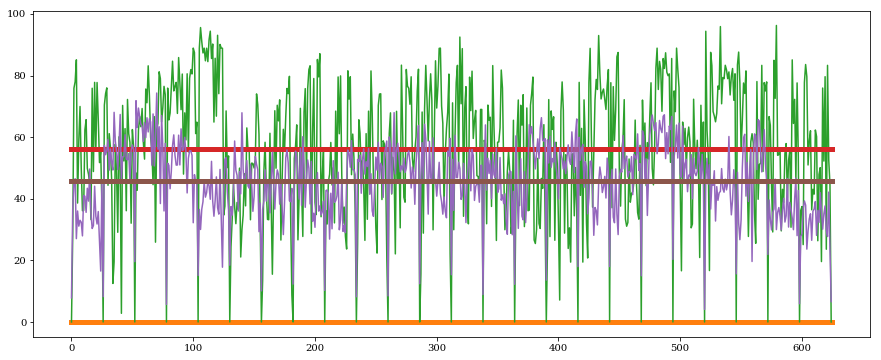

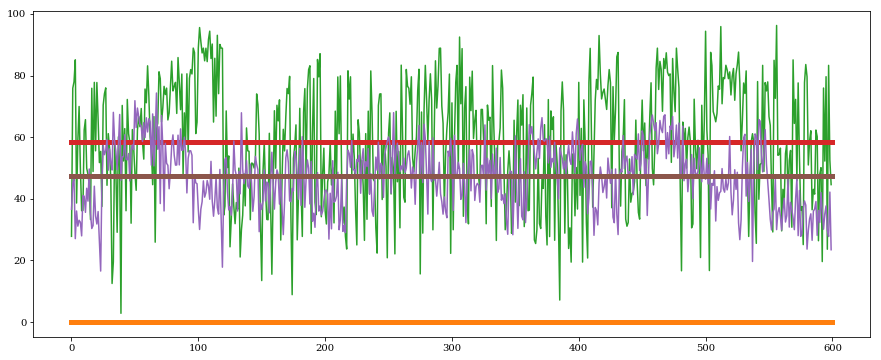

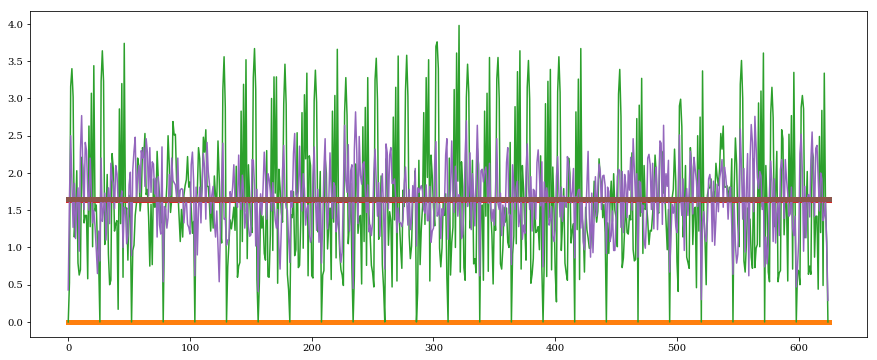

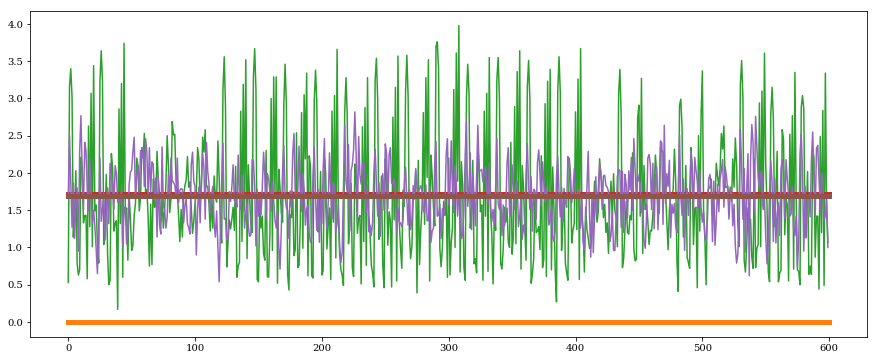

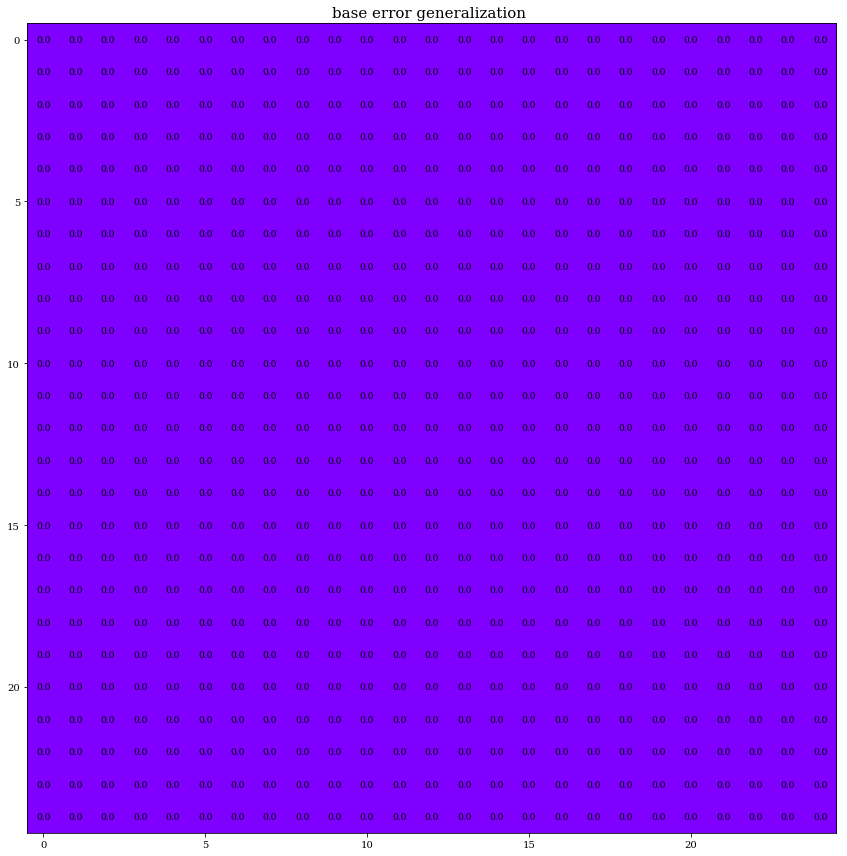

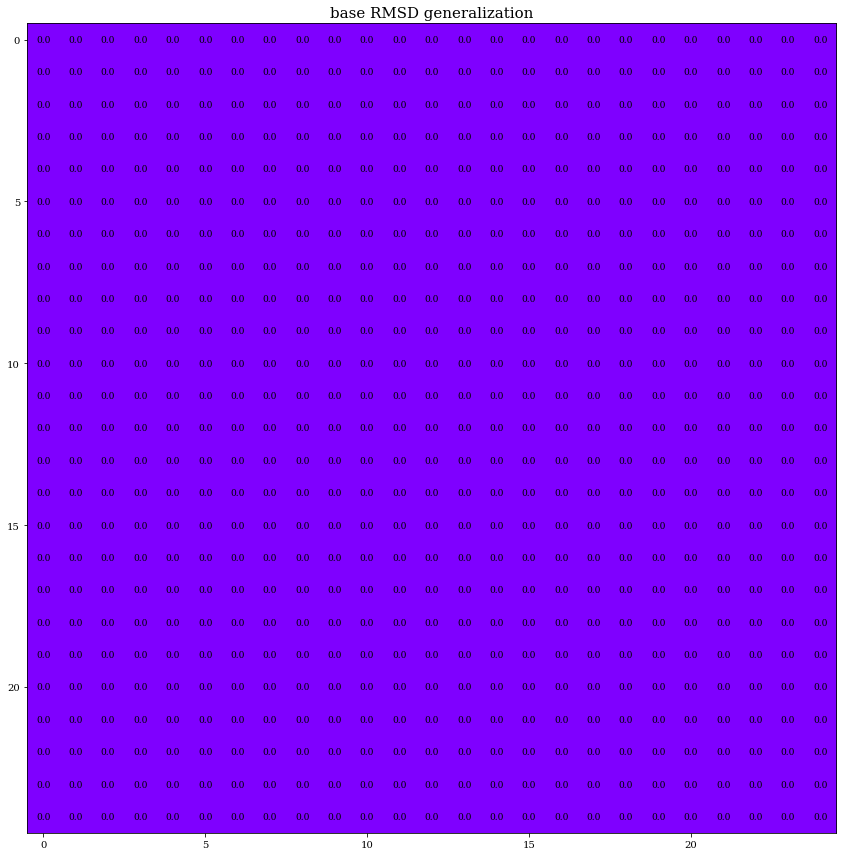

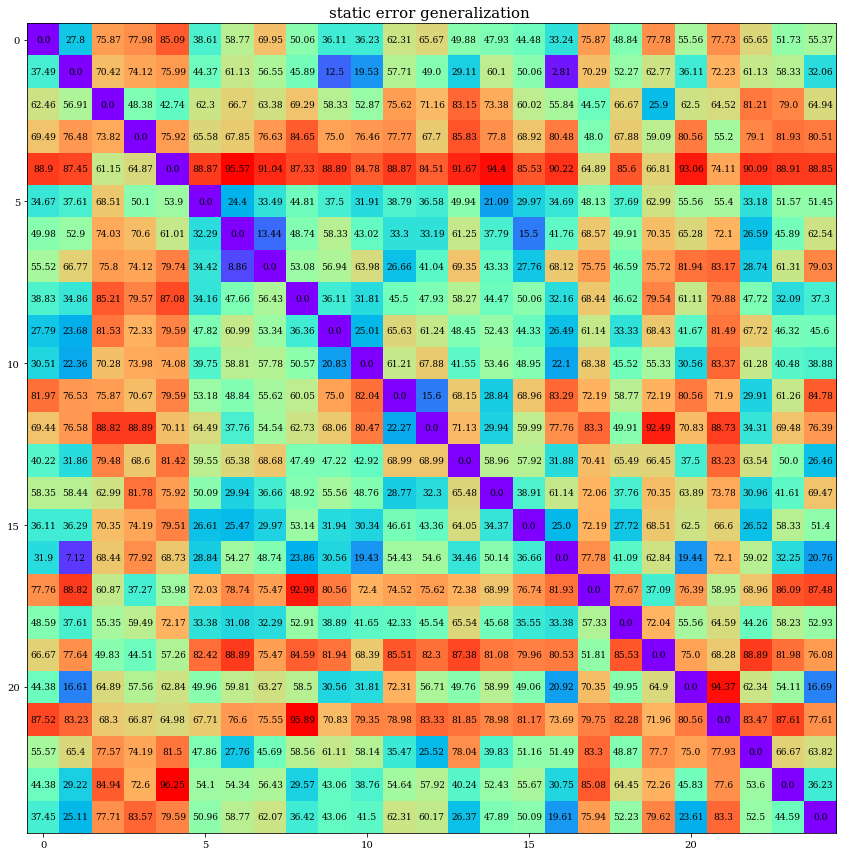

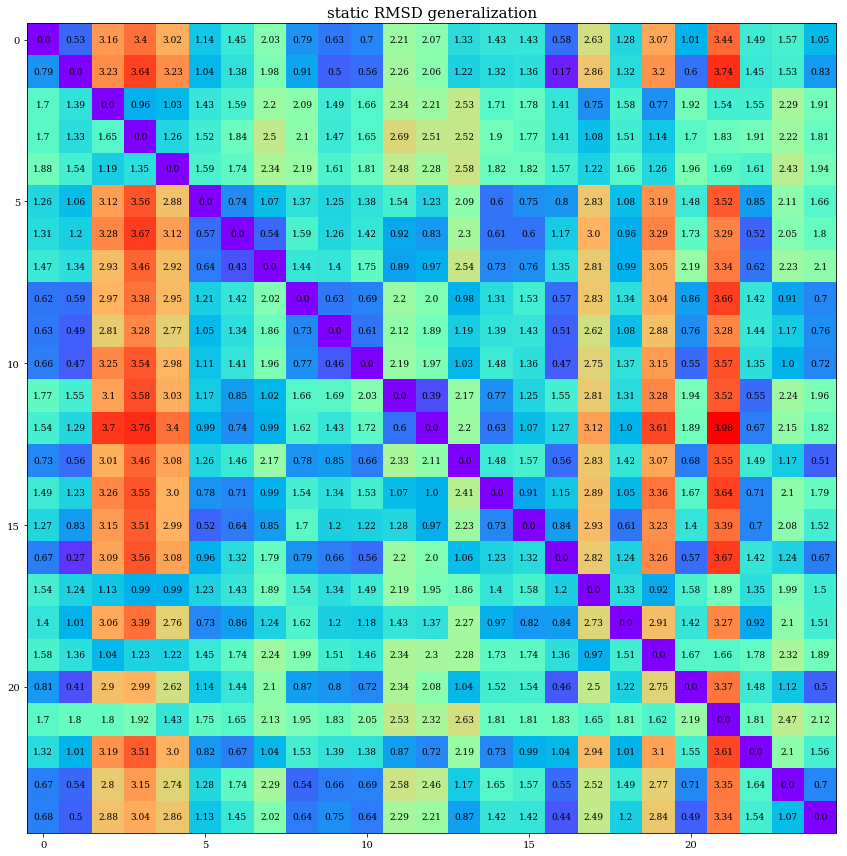

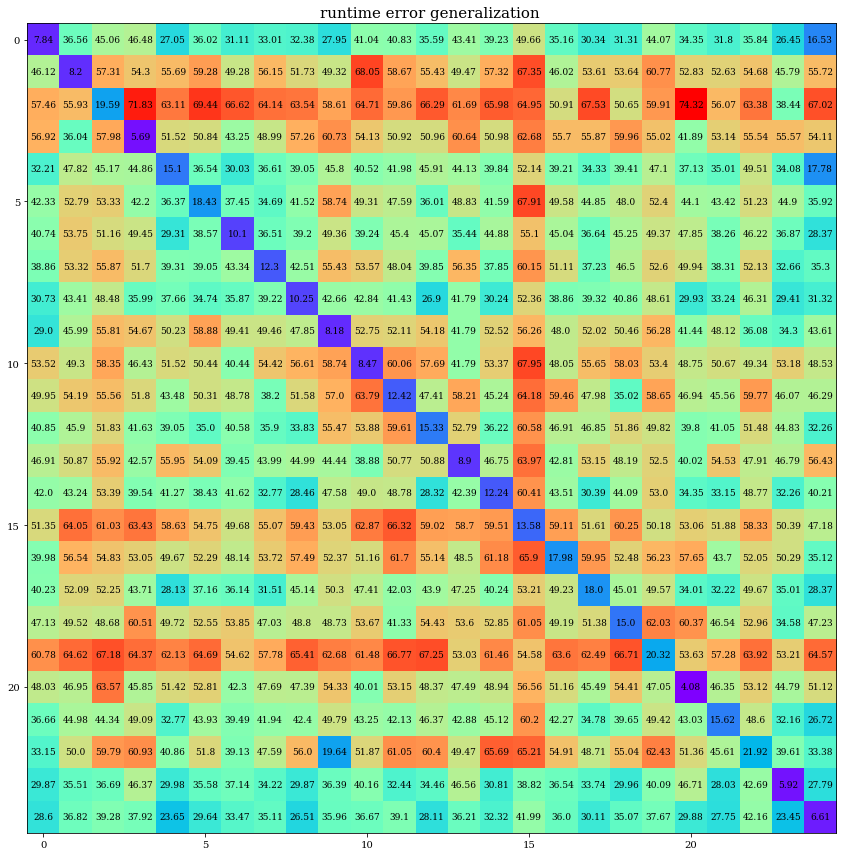

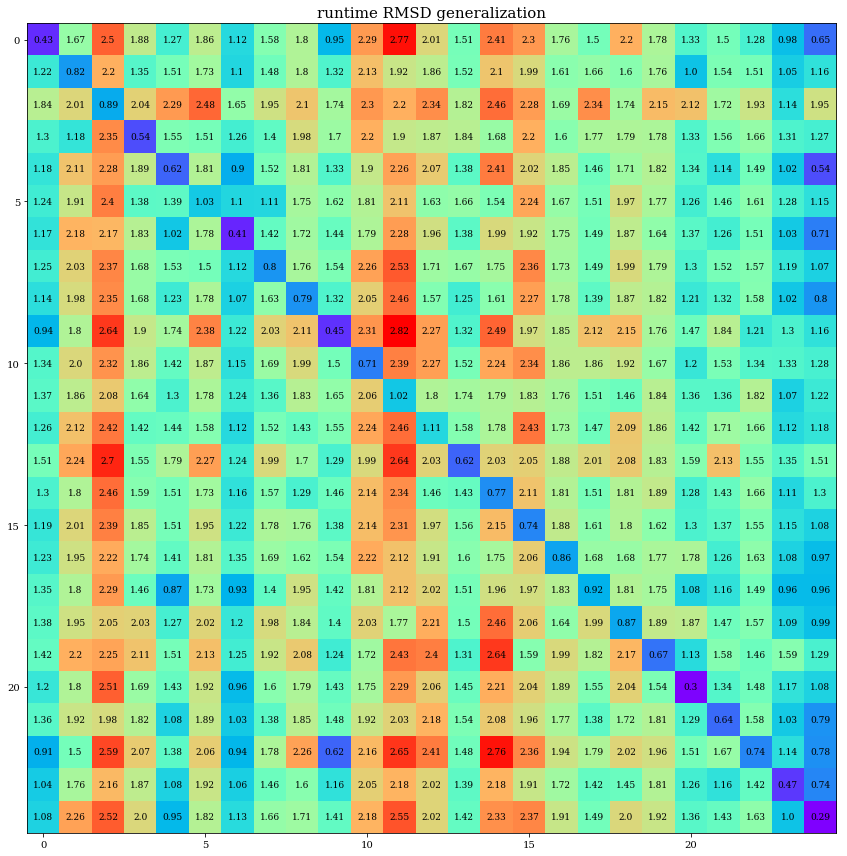

In [14]:
def get_errors_and_rmsd_without_self(results, errors, rms, errors_without_self, RMSDs_without_self):
    get_errors_and_rmsd(results, errors, rms)
    for i in range(0,N):
        for j in range(0,N):            
            if(i!=j):
                errors_without_self.append(errors[i*N+j])
                RMSDs_without_self.append(rms[i*N+j])

base_errors = []
base_rmsd = []
base_errors_without_self = []
base_rmsd_without_self = []
get_errors_and_rmsd_without_self(base_results, base_errors, base_rmsd, base_errors_without_self, base_rmsd_without_self)
base_std_error = np.std(base_errors)
base_std_error_without = np.std(base_errors_without_self)
print(base_std_error, ' ', base_std_error_without)

static_errors = []
static_rmsd = []
static_errors_without_self = []
static_rmsd_without_self = []
get_errors_and_rmsd_without_self(static_results, static_errors, static_rmsd, static_errors_without_self, static_rmsd_without_self)                
static_std_error = np.std(static_errors)
static_std_error_without = np.std(static_errors_without_self)
print(static_std_error, ' ', static_std_error_without)

runtime_errors = []
runtime_rmsd = []
runtime_errors_without_self = []
runtime_rmsd_without_self = []
get_errors_and_rmsd_without_self(runtime_results, runtime_errors, runtime_rmsd, runtime_errors_without_self, runtime_rmsd_without_self)                
runtime_std_error = np.std(runtime_errors)
runtime_std_error_without = np.std(runtime_errors_without_self)
print(runtime_std_error, ' ', runtime_std_error_without)

plt.figure(6, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(7, figsize=(15,6))
plt.plot(base_errors_without_self)
mean = np.mean(base_errors_without_self)
plt.plot([0, len(base_errors_without_self)], [mean, mean], linewidth=5)
plt.plot(static_errors_without_self)
mean = np.mean(static_errors_without_self)
plt.plot([0, len(static_errors_without_self)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_without_self)
mean = np.mean(runtime_errors_without_self)
plt.plot([0, len(runtime_errors_without_self)], [mean, mean], linewidth=5)
plt.show()

plt.figure(8, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

plt.figure(9, figsize=(15,6))
plt.plot(base_rmsd_without_self)
mean = np.mean(base_rmsd_without_self)
plt.plot([0, len(base_rmsd_without_self)], [mean, mean], linewidth=5)
plt.plot(static_rmsd_without_self)
mean = np.mean(static_rmsd_without_self)
plt.plot([0, len(static_rmsd_without_self)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd_without_self)
mean = np.mean(runtime_rmsd_without_self)
plt.plot([0, len(runtime_rmsd_without_self)], [mean, mean], linewidth=5)
plt.show()

def get_error_rmsd_matrices(errors, rmsd, error_matrix, rmsd_matrix):
    for i in range(0,N):
        for j in range(0,N):
            error_matrix[i][j] = errors[N*i+j]
            rmsd_matrix[i][j] = rmsd[N*i+j]
            
base_error_matrix = np.empty([N,N], dtype=float)
base_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(base_errors, base_rmsd, base_error_matrix, base_rmsd_matrix)

static_error_matrix = np.empty([N,N], dtype=float)
static_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(static_errors, static_rmsd, static_error_matrix, static_rmsd_matrix)

runtime_error_matrix = np.empty([N,N], dtype=float)
runtime_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(runtime_errors, runtime_rmsd, runtime_error_matrix, runtime_rmsd_matrix)

def plot_matrices(error_matrix, rmsd_matrix, mode):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization.png', dpi=300)


    #Display RMSD matrix
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(rmsd_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, rmsd_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" RMSD generalization", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_rmsd_generalization.png', dpi=300)
    
plot_matrices(base_error_matrix, base_rmsd_matrix, 'base')
plot_matrices(static_error_matrix, static_rmsd_matrix, 'static')    
plot_matrices(runtime_error_matrix, runtime_rmsd_matrix, 'runtime')    

In [15]:
def xp3(train_set, test_set, mode):
    for i in range(0,N,5):    
        print('training model on protocols', str(i), '-', str(i+4))
        train = series_to_supervised(list(train_set[i]), size_of_window, 1)
        test = series_to_supervised(list(test_set[i]), size_of_window, 1) 
        train_X_block, train_Y_block, test_X, test_Y = reshape(train, test)
        for j in range(i,i+5):
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1)
            train_X, train_Y, _, _ = reshape(train, test)
            train_X_block = np.concatenate((train_X_block, train_X), 0)
            train_Y_block = np.concatenate((train_Y_block, train_Y), 0)
        
        model = keras_model(train_X.shape[2], train_X.shape[1])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X_block, train_Y_block, test_X, test_Y, mode, i+2000)#FIXME: split train_and_save into 2 def
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        
        for j in range(0,N):
            print('using model trained on protocols', str(i), '-', str(i+4), ' on data coming from ', str(j))
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1) 
            train_X, train_Y, test_X, test_Y = reshape(train, test)
            predict_start = datetime.datetime.now()
            match_ratio, RMSD = predict(model, test_X, test_Y)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print('RMSD = ', RMSD)
            print(match_ratio, '% error')
            print('training duration = ', train_duration)
            print('prediction duration = ', predict_duration)
            yield match_ratio, RMSD, train_duration, predict_duration

runtime_results = xp3(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_results)

static_results = xp3(static_train, static_test, 'static')
static_results = list(static_results)

base_results = xp3(base_train, base_test, 'base')
base_results = list(base_results)

training model on protocols 0 - 4
Train on 8603 samples, validate on 956 samples
Epoch 1/54
8603/8603 [==============================] - 33s 4ms/step - loss: 1.2207 - val_loss: 1.2715
Epoch 2/54
8603/8603 [==============================] - 8s 879us/step - loss: 0.5726 - val_loss: 1.2996
Epoch 3/54
8603/8603 [==============================] - 8s 878us/step - loss: 0.4178 - val_loss: 1.0324
Epoch 4/54
8603/8603 [==============================] - 8s 880us/step - loss: 0.3497 - val_loss: 0.9547
Epoch 5/54
8603/8603 [==============================] - 8s 877us/step - loss: 0.3089 - val_loss: 0.9348
Epoch 6/54
8603/8603 [==============================] - 8s 875us/step - loss: 0.2911 - val_loss: 0.9500
Epoch 7/54
8603/8603 [==============================] - 8s 881us/step - loss: 0.2707 - val_loss: 0.8967
Epoch 8/54
8603/8603 [==============================] - 8s 880us/step - loss: 0.2645 - val_loss: 0.8366
Epoch 9/54
8603/8603 [==============================] - 8s 881us/step - loss: 0.2495 - v

8758/8758 [==============================] - 8s 868us/step - loss: 0.2823 - val_loss: 0.2301
Epoch 00020: early stopping
using model trained on protocols 5 - 9  on data coming from  0
RMSD =  1.04
31.53 % match
training duration =  0:03:00.605781
prediction duration =  0:00:08.065460
using model trained on protocols 5 - 9  on data coming from  1
RMSD =  1.87
46.34 % match
training duration =  0:03:00.605781
prediction duration =  0:00:00.117311
using model trained on protocols 5 - 9  on data coming from  2
RMSD =  2.22
45.22 % match
training duration =  0:03:00.605781
prediction duration =  0:00:00.111296
using model trained on protocols 5 - 9  on data coming from  3
RMSD =  1.56
37.77 % match
training duration =  0:03:00.605781
prediction duration =  0:00:00.096228
using model trained on protocols 5 - 9  on data coming from  4
RMSD =  0.95
31.840000000000003 % match
training duration =  0:03:00.605781
prediction duration =  0:00:00.105254
using model trained on protocols 5 - 9  on dat

RMSD =  0.72
10.939999999999998 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.110294
using model trained on protocols 10 - 14  on data coming from  11
RMSD =  1.09
10.180000000000007 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.102272
using model trained on protocols 10 - 14  on data coming from  12
RMSD =  1.17
18.0 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.125334
using model trained on protocols 10 - 14  on data coming from  13
RMSD =  0.6
11.120000000000005 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.126337
using model trained on protocols 10 - 14  on data coming from  14
RMSD =  0.76
14.189999999999998 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.131350
using model trained on protocols 10 - 14  on data coming from  15
RMSD =  1.92
57.54 % match
training duration =  0:02:46.059177
prediction duration =  0:00:00.120321
using model tr

Train on 8316 samples, validate on 925 samples
Epoch 1/54
8316/8316 [==============================] - 34s 4ms/step - loss: 0.7695 - val_loss: 0.2776
Epoch 2/54
8316/8316 [==============================] - 7s 880us/step - loss: 0.4061 - val_loss: 0.2642
Epoch 3/54
8316/8316 [==============================] - 7s 884us/step - loss: 0.3034 - val_loss: 0.2257
Epoch 4/54
8316/8316 [==============================] - 7s 879us/step - loss: 0.2465 - val_loss: 0.1841
Epoch 5/54
8316/8316 [==============================] - 7s 882us/step - loss: 0.2161 - val_loss: 0.1422
Epoch 6/54
8316/8316 [==============================] - 7s 881us/step - loss: 0.1912 - val_loss: 0.1636
Epoch 7/54
8316/8316 [==============================] - 7s 885us/step - loss: 0.1769 - val_loss: 0.1472
Epoch 8/54
8316/8316 [==============================] - 7s 882us/step - loss: 0.1590 - val_loss: 0.1531
Epoch 9/54
8316/8316 [==============================] - 7s 880us/step - loss: 0.1485 - val_loss: 0.1316
Epoch 10/54
8316/8

RMSD =  0.33
11.11 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.107254
using model trained on protocols 0 - 4  on data coming from  11
RMSD =  2.91
69.02 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.150402
using model trained on protocols 0 - 4  on data coming from  12
RMSD =  2.76
62.31 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.154379
using model trained on protocols 0 - 4  on data coming from  13
RMSD =  1.2
31.959999999999994 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.090209
using model trained on protocols 0 - 4  on data coming from  14
RMSD =  1.99
62.38 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.157387
using model trained on protocols 0 - 4  on data coming from  15
RMSD =  1.95
53.49 % match
training duration =  0:01:01.802908
prediction duration =  0:00:00.145389
using model trained on protocols 0 - 4  on data coming from  1

RMSD =  0.68
33.290000000000006 % match
training duration =  0:01:22.240160
prediction duration =  0:00:08.531231
using model trained on protocols 10 - 14  on data coming from  1
RMSD =  0.39
15.510000000000005 % match
training duration =  0:01:22.240160
prediction duration =  0:00:00.101270
using model trained on protocols 10 - 14  on data coming from  2
RMSD =  3.72
66.46000000000001 % match
training duration =  0:01:22.240160
prediction duration =  0:00:00.091210
using model trained on protocols 10 - 14  on data coming from  3
RMSD =  4.06
72.33 % match
training duration =  0:01:22.240160
prediction duration =  0:00:00.081186
using model trained on protocols 10 - 14  on data coming from  4
RMSD =  3.59
70.49 % match
training duration =  0:01:22.240160
prediction duration =  0:00:00.074165
using model trained on protocols 10 - 14  on data coming from  5
RMSD =  0.39
15.450000000000003 % match
training duration =  0:01:22.240160
prediction duration =  0:00:00.120318
using model traine

RMSD =  0.9
30.560000000000002 % match
training duration =  0:01:22.042698
prediction duration =  0:00:00.107787
using model trained on protocols 15 - 19  on data coming from  21
RMSD =  1.39
42.25 % match
training duration =  0:01:22.042698
prediction duration =  0:00:00.092247
using model trained on protocols 15 - 19  on data coming from  22
RMSD =  0.9
41.02 % match
training duration =  0:01:22.042698
prediction duration =  0:00:00.171456
using model trained on protocols 15 - 19  on data coming from  23
RMSD =  2.24
54.0 % match
training duration =  0:01:22.042698
prediction duration =  0:00:00.106813
using model trained on protocols 15 - 19  on data coming from  24
RMSD =  1.12
33.28 % match
training duration =  0:01:22.042698
prediction duration =  0:00:00.124304
training model on protocols 20 - 24
Train on 7256 samples, validate on 807 samples
Epoch 1/54
7256/7256 [==============================] - 35s 5ms/step - loss: 0.1813 - val_loss: 0.0038
Epoch 2/54
7256/7256 [=============

RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.093246
using model trained on protocols 0 - 4  on data coming from  13
RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.087198
using model trained on protocols 0 - 4  on data coming from  14
RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.083195
using model trained on protocols 0 - 4  on data coming from  15
RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.084224
using model trained on protocols 0 - 4  on data coming from  16
RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.094220
using model trained on protocols 0 - 4  on data coming from  17
RMSD =  0.0
0.0 % match
training duration =  0:01:00.062934
prediction duration =  0:00:00.056117
using model trained on protocols 0 - 4  on data coming from  18
RMSD =  0.0
0.0 % match
trai

RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.084190
using model trained on protocols 10 - 14  on data coming from  5
RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.077173
using model trained on protocols 10 - 14  on data coming from  6
RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.093228
using model trained on protocols 10 - 14  on data coming from  7
RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.090211
using model trained on protocols 10 - 14  on data coming from  8
RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.085197
using model trained on protocols 10 - 14  on data coming from  9
RMSD =  0.0
0.0 % match
training duration =  0:01:01.551060
prediction duration =  0:00:00.078178
using model trained on protocols 10 - 14  on data coming from  10
RMSD =  0.0
0.0 % mat

Train on 4729 samples, validate on 526 samples
Epoch 1/54
4729/4729 [==============================] - 33s 7ms/step - loss: 0.1368 - val_loss: 5.5654e-05
Epoch 2/54
4729/4729 [==============================] - 4s 926us/step - loss: 1.6422e-05 - val_loss: 1.7278e-06
Epoch 3/54
4729/4729 [==============================] - 4s 926us/step - loss: 3.7787e-07 - val_loss: 3.6402e-08
Epoch 4/54
4729/4729 [==============================] - 4s 933us/step - loss: 9.8884e-09 - val_loss: 6.7813e-10
Epoch 5/54
4729/4729 [==============================] - 4s 931us/step - loss: 3.7832e-05 - val_loss: 0.0018
Epoch 6/54
4729/4729 [==============================] - 4s 928us/step - loss: 8.9279e-04 - val_loss: 2.9333e-06
Epoch 00006: early stopping
using model trained on protocols 20 - 24  on data coming from  0
RMSD =  0.0
0.0 % match
training duration =  0:00:55.354868
prediction duration =  0:00:09.080065
using model trained on protocols 20 - 24  on data coming from  1
RMSD =  0.0
0.0 % match
training d

0.0   0.0
23.1517985252   19.5446290349
12.1868640137   7.29420025705


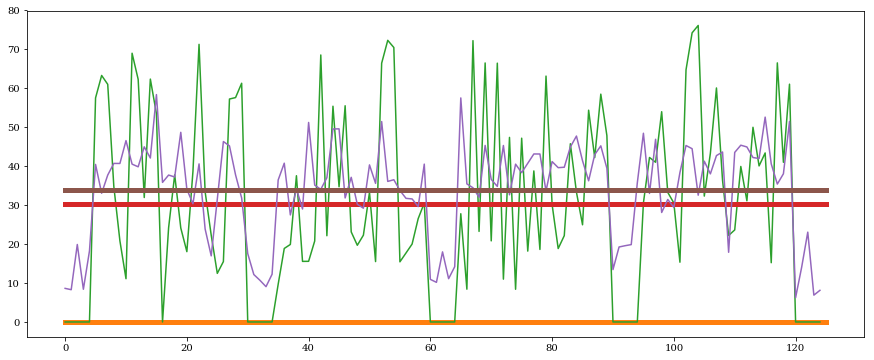

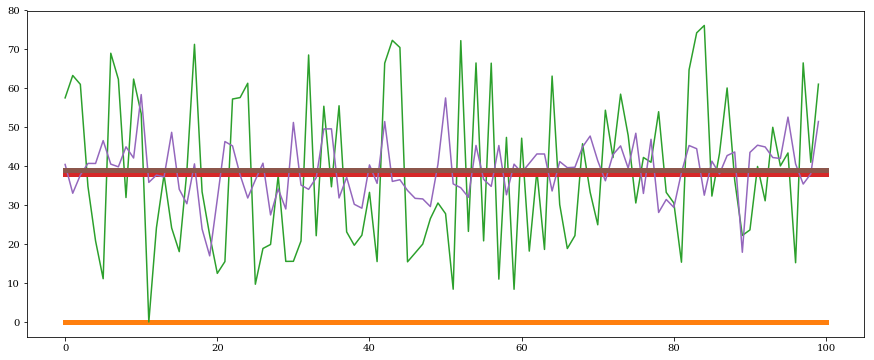

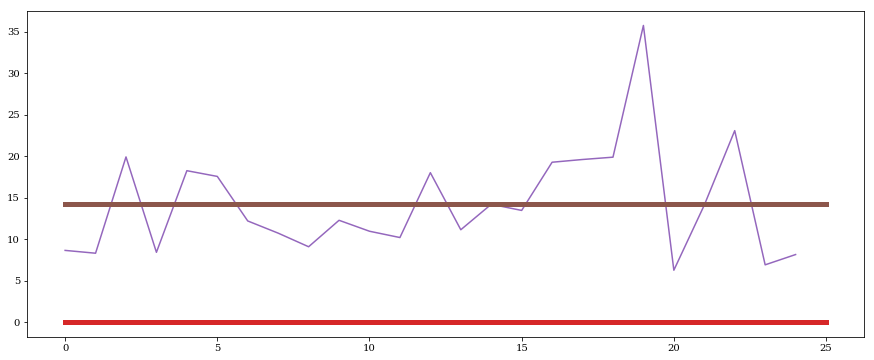

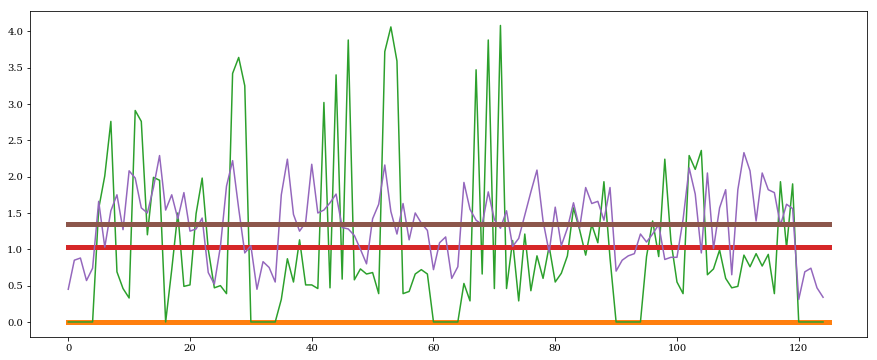

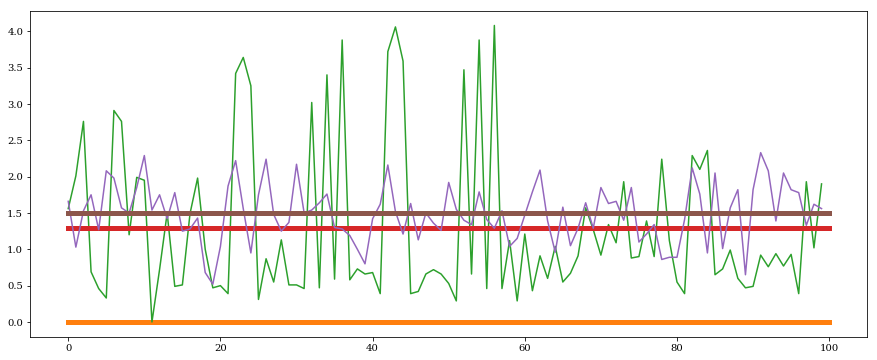

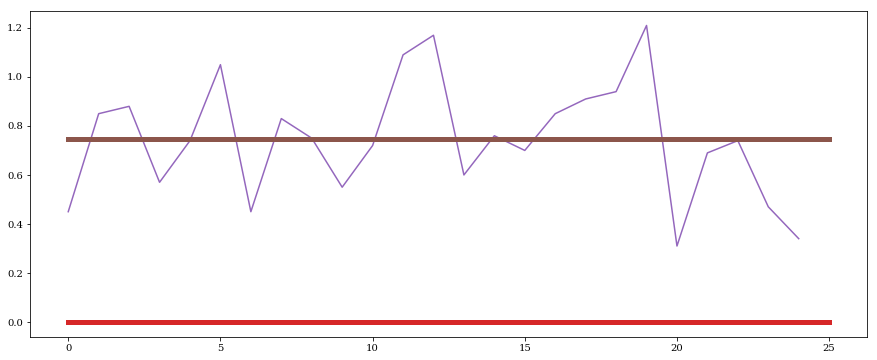

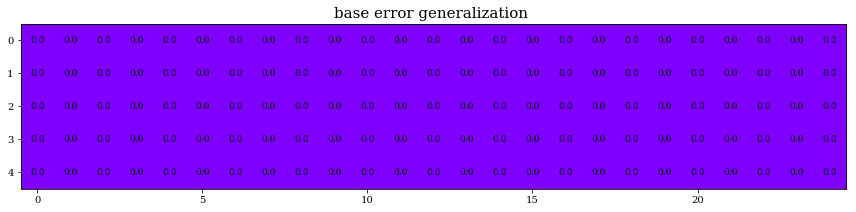

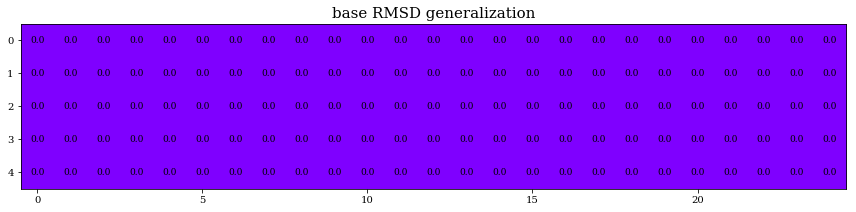

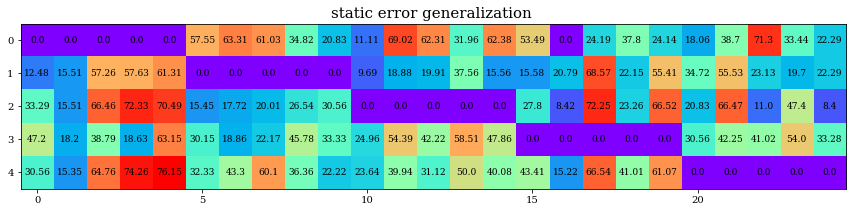

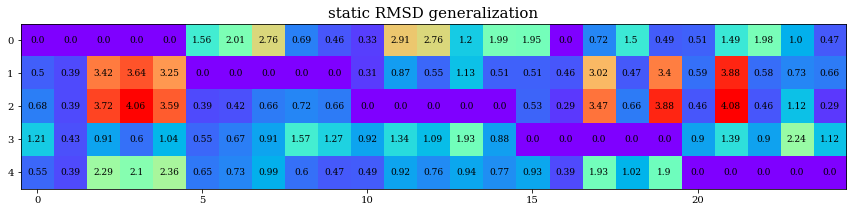

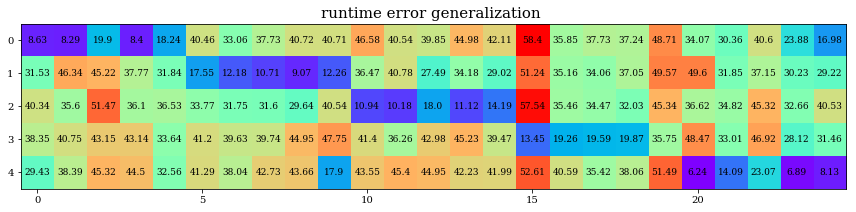

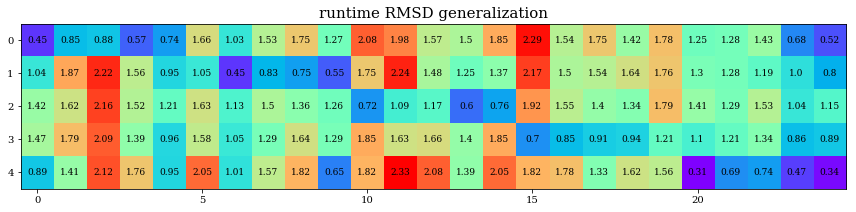

In [16]:
def get_errors_and_rmsd_without_self2(results, errors, rms, errors_without_self, RMSDs_without_self, self_errors, self_RMSDs, skip=5):
    get_errors_and_rmsd(results, errors, rms)
    s = 0
    r = 0
    for i in range(0,len(errors)):
        if s < skip:
            self_errors.append(errors[i])
            self_RMSDs.append(rms[i])
            s = s + 1            
        else:
            errors_without_self.append(errors[i])
            RMSDs_without_self.append(rms[i])
            r = r + 1           
            if (r >= N):
                r = 0
                s = 0
        
base_errors = []
base_rmsd = []
base_errors_w = []
base_rmsd_w = []
self_base_errors = []
self_base_rmsd = []
get_errors_and_rmsd_without_self2(base_results, base_errors, base_rmsd, base_errors_w, base_rmsd_w, self_base_errors, self_base_rmsd)
base_std_error = np.std(base_errors)
base_std_error_w = np.std(base_errors_w)
print(base_std_error, ' ', base_std_error_w)

static_errors = []
static_rmsd = []
static_errors_w = []
static_rmsd_w = []
self_static_errors = []
self_static_rmsd = []
get_errors_and_rmsd_without_self2(static_results, static_errors, static_rmsd, static_errors_w, static_rmsd_w, self_static_errors, self_static_rmsd)                
static_std_error = np.std(static_errors)
static_std_error_w = np.std(static_errors_w)
print(static_std_error, ' ', static_std_error_w)

runtime_errors = []
runtime_rmsd = []
runtime_errors_w = []
runtime_rmsd_w = []
self_runtime_errors = []
self_runtime_rmsd = []
get_errors_and_rmsd_without_self2(runtime_results, runtime_errors, runtime_rmsd, runtime_errors_w, runtime_rmsd_w, self_runtime_errors, self_runtime_rmsd)                
runtime_std_error = np.std(runtime_errors)
runtime_std_error_w = np.std(runtime_errors_w)
print(runtime_std_error, ' ', runtime_std_error_w)

plt.figure(10, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(11, figsize=(15,6))
plt.plot(base_errors_w)
mean = np.mean(base_errors_w)
plt.plot([0, len(base_errors_w)], [mean, mean], linewidth=5)
plt.plot(static_errors_w)
mean = np.mean(static_errors_w)
plt.plot([0, len(static_errors_w)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_w)
mean = np.mean(runtime_errors_w)
plt.plot([0, len(runtime_errors_w)], [mean, mean], linewidth=5)
plt.show()

plt.figure(12, figsize=(15,6))
plt.plot(self_base_errors)
mean = np.mean(self_base_errors)
plt.plot([0, len(self_base_errors)], [mean, mean], linewidth=5)
plt.plot(self_static_errors)
mean = np.mean(self_static_errors)
plt.plot([0, len(self_static_errors)], [mean, mean], linewidth=5)
plt.plot(self_runtime_errors)
mean = np.mean(self_runtime_errors)
plt.plot([0, len(self_runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(13, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

plt.figure(14, figsize=(15,6))
plt.plot(base_rmsd_w)
mean = np.mean(base_rmsd_w)
plt.plot([0, len(base_rmsd_w)], [mean, mean], linewidth=5)
plt.plot(static_rmsd_w)
mean = np.mean(static_rmsd_w)
plt.plot([0, len(static_rmsd_w)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd_w)
mean = np.mean(runtime_rmsd_w)
plt.plot([0, len(runtime_rmsd_w)], [mean, mean], linewidth=5)
plt.show()

plt.figure(15, figsize=(15,6))
plt.plot(self_base_rmsd)
mean = np.mean(self_base_rmsd)
plt.plot([0, len(self_base_rmsd)], [mean, mean], linewidth=5)
plt.plot(self_static_rmsd)
mean = np.mean(self_static_rmsd)
plt.plot([0, len(self_static_rmsd)], [mean, mean], linewidth=5)
plt.plot(self_runtime_rmsd)
mean = np.mean(self_runtime_rmsd)
plt.plot([0, len(self_runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

def get_error_rmsd_matrices2(errors, rmsd, error_matrix, rmsd_matrix, length=N):
    for i in range(0, len(errors)):
        row = math.floor(i/length)
        col = i % length
        error_matrix[row][col] = errors[i]
        rmsd_matrix[row][col] = rmsd[i]
            
x = math.floor(len(base_errors)/N)
y = N
base_error_matrix = np.empty([x,y], dtype=float)
base_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(base_errors, base_rmsd, base_error_matrix, base_rmsd_matrix)

x = math.floor(len(static_errors)/N)
static_error_matrix = np.empty([x,y], dtype=float)
static_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(static_errors, static_rmsd, static_error_matrix, static_rmsd_matrix)

x = math.floor(len(runtime_errors)/N)
runtime_error_matrix = np.empty([x,y], dtype=float)
runtime_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(runtime_errors, runtime_rmsd, runtime_error_matrix, runtime_rmsd_matrix)


def plot_matrices2(error_matrix, rmsd_matrix, mode, x=N, y=N):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization.png', dpi=300)


    #Display RMSD matrix
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(rmsd_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, rmsd_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" RMSD generalization", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_rmsd_generalization.png', dpi=300)

plot_matrices2(base_error_matrix, base_rmsd_matrix, 'base', x=5)
plot_matrices2(static_error_matrix, static_rmsd_matrix, 'static', x=5)    
plot_matrices2(runtime_error_matrix, runtime_rmsd_matrix, 'runtime', x=5)    